In [63]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import copy
import category_encoders as ce

from category_encoders import TargetEncoder
from category_encoders import CountEncoder
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import datasets, metrics
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None # display all columns


from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [5]:
school_grades_df = pd.read_csv('school_grades_dataset.csv')

## Binarna klasyfikacja vs 5-poziomowa klasyfikacja
Przeprowadzimy dwie klasyfikacje:

Binarną, dzieląc uczniów na tych którzy zaliczyli rok oraz oblewających

Pięciopoziomową, podział wyników na oceny według hiszpańskiego systemu edukacji 


In [6]:
s1 = school_grades_df.copy()
s1 = pd.cut(s1["G3"], bins=[-1, 9,20], labels=["fail","pass"])
s1 = s1.value_counts().rename_axis('G3').reset_index(name='counts')
s1

,G3,counts
0,pass,549
1,fail,100


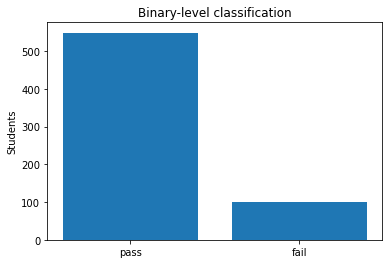

In [7]:
plt.bar(s1['G3'], s1['counts'])
plt.title("Binary-level classification")
plt.ylabel("Students")
plt.show()


In [8]:
s2 = school_grades_df.copy()
s2 = pd.cut(s2["G3"], bins=[-1, 9, 11, 13,15,np.inf], labels=[5,4,3,2,1])
s2 = s2.value_counts().rename_axis('G3').reset_index(name='counts')
s2

,G3,counts
0,4,201
1,3,154
2,2,112
3,5,100
4,1,82


In [9]:
grades= {1:"1 excellent", 2:"2 good", 3:"3 satisfactory", 4:"4 sufficient", 5:"5 fail"}
s2 = s2.sort_values(by="G3",ascending=False)
s2.G3 = s2.G3.map(grades)


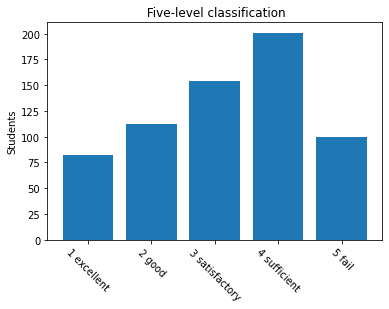

In [10]:
plt.bar(s2['G3'], s2['counts'])
plt.xticks(rotation=-45)
plt.title(" Five-level classification")
plt.ylabel("Students")
plt.show()

## Kodowanie zmiennych kategorycznych

In [11]:

encoder=ce.TargetEncoder(cols=['Mjob','Fjob','reason','guardian'])
school_grades_df=encoder.fit_transform(school_grades_df,school_grades_df.G3)
# school_grades_df

In [12]:
dict2= {'yes':1, 'no':0}
school_grades_df.schoolsup=school_grades_df.schoolsup.map(dict2)
school_grades_df.famsup=school_grades_df.famsup.map(dict2)
school_grades_df.paid=school_grades_df.paid.map(dict2)
school_grades_df.activities=school_grades_df.activities.map(dict2)
school_grades_df.nursery=school_grades_df.nursery.map(dict2)
school_grades_df.higher=school_grades_df.higher.map(dict2)
school_grades_df.internet=school_grades_df.internet.map(dict2)
school_grades_df.romantic=school_grades_df.romantic.map(dict2)


In [13]:

encoder=ce.OneHotEncoder(cols=['school','sex','address','famsize','Pstatus'])
school_grades_df=encoder.fit_transform(school_grades_df)
# school_grades_df

Kategorie które przyjmowały wartości binarne zakodowane jako Yes i No zostały zmapowane na wartości odpowiednio 1 i 0.

W przypadku kilku kolumn binarnych dotyczących płci, uczęszczanej szkoły czy statusu współżycia rodziców, zastosowaliśmy przekształcenie przez one hot encoding tak by nie „dyskryminować” zerami np.płci.

Etykiety wielopoziomowe zostały przekształcone przy pomocy target encoding, próbowaliśmy także count encoding lecz modele wypadały minimalnie gorzej.

Skalowanie zmiennych - model random forest nie potrzebuje normalizacji i jest odporny na wartości odstające

In [14]:
school_grades_df_1 = school_grades_df.copy()
school_grades_df_1['G3'] = pd.cut(school_grades_df_1["G3"], bins=[-1, 9,20], labels=[0,1])
school_grades_df_1.head()

,school_1,school_2,sex_1,sex_2,age,address_1,address_2,famsize_1,famsize_2,Pstatus_1,Pstatus_2,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,1,0,18,1,0,1,0,1,0,4,4,11.044444,13.583333,11.547368,11.896703,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,1
1,1,0,1,0,17,1,0,1,0,0,1,1,1,11.044444,11.891008,11.547368,12.202614,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,1
2,1,0,1,0,15,1,0,0,1,0,1,1,1,11.044444,11.891008,10.694444,11.896703,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,1
3,1,0,1,0,15,1,0,1,0,0,1,4,2,13.062500,11.629834,12.181208,11.896703,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,1
4,1,0,1,0,16,1,0,1,0,0,1,3,3,11.670543,11.891008,12.181208,12.202614,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,1


In [15]:
school_grades_df_2 = school_grades_df.copy()
school_grades_df_2["G3"]=pd.cut(school_grades_df_2["G3"], bins=[-1, 9, 11, 13,15,np.inf], labels=[5,4,3,2,1])
school_grades_df_2.head()

,school_1,school_2,sex_1,sex_2,age,address_1,address_2,famsize_1,famsize_2,Pstatus_1,Pstatus_2,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,1,0,18,1,0,1,0,1,0,4,4,11.044444,13.583333,11.547368,11.896703,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,4
1,1,0,1,0,17,1,0,1,0,0,1,1,1,11.044444,11.891008,11.547368,12.202614,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,4
2,1,0,1,0,15,1,0,0,1,0,1,1,1,11.044444,11.891008,10.694444,11.896703,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,3
3,1,0,1,0,15,1,0,1,0,0,1,4,2,13.062500,11.629834,12.181208,11.896703,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,2
4,1,0,1,0,16,1,0,1,0,0,1,3,3,11.670543,11.891008,12.181208,12.202614,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,3


# Klasyfikacja binarna
W klasyfikacji binarnej, z uwagi nie niezrównoważenie klas, do oceny modeli używamy recall, precision oraz ich kombinacji f1.

### Model z G1 i G2 - LogisticRegression
Łatwiejsza wersja przewidywania uwzględniająca semestralne oceny 

In [16]:
y = np.array(school_grades_df_1['G3'])
X = school_grades_df_1.drop(['G3'],axis=1)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

In [18]:
# print(X.shape,X_train.shape, X_val.shape, X_test.shape)

In [19]:
## parametry podstawowe
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train,y_train)
y_hat = lr.predict(X_val)

y_hat_train = lr.predict(X_train)

print("zbiór treningowy")
print("recall    ",recall_score(y_train,y_hat_train))
print("precision ",precision_score(y_train,y_hat_train))
print("f1        ",f1_score(y_train,y_hat_train))
print()
print("zbiór testowy")
print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

zbiór treningowy
recall     0.9789473684210527
precision  0.96875
f1         0.9738219895287958

zbiór testowy
recall     0.9743589743589743
precision  0.9661016949152542
f1         0.9702127659574468


Wyniki na zbiorze treningowym i testowym są podobne – model nie jest przeuczony 

In [20]:
# strojenie 
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid={
    'C':[0.1,0.25,0.5,0.75,1,1.25,1.5],
    'penalty': ['l2','l1'],
}
lr = LogisticRegression(max_iter=1000)
grid=GridSearchCV(lr,param_grid,cv=5,n_jobs=-1,scoring=metrics.recall_score)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


y_hat = grid_result.predict(X_val)

y_hat_train = grid_result.predict(X_train)

print("zbiór treningowy")
print("recall    ",recall_score(y_train,y_hat_train))
print("precision ",precision_score(y_train,y_hat_train))
print("f1        ",f1_score(y_train,y_hat_train))
print()
print("zbiór testowy")
print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

Best: nan using {'C': 0.1, 'penalty': 'l2'}
zbiór treningowy
recall     0.9736842105263158
precision  0.8644859813084113
f1         0.9158415841584159

zbiór testowy
recall     1.0
precision  0.8931297709923665
f1         0.9435483870967742


To konkretne strojenie dało słabe skutki 

In [25]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=3,verbosity=2,scoring='f1')

tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/400 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9616965586078052

Generation 2 - Current best internal CV score: 0.9629383195420932

Generation 3 - Current best internal CV score: 0.9629383195420932

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=9, min_samples_split=11, n_estimators=100)


TPOTClassifier(generations=3, scoring='f1', verbosity=2)

In [26]:
tpot.score(X_test, y_test)
y_hat=tpot.predict(X_val)

print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

recall     0.9829059829059829
precision  0.9426229508196722
f1         0.9623430962343097


Zautomatyzowany pakiet tpot wybrał inny model, ale osiągną podobne wyniki do regresji logistycznej 

### Model bez G1 i G2
Przewidywanie bez ocen semestralnych 

In [27]:
y = np.array(school_grades_df_1['G3'])
X = school_grades_df_1.drop(['G3','G2','G1'],axis=1)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

In [29]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=1)
model.fit(X_train, y_train)

y_hat = model.predict(X_val)


print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

recall     0.9829059829059829
precision  0.9126984126984127
f1         0.9465020576131686


In [31]:
model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 1}

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid={
    'n_estimators':[25,50,75],
    'algorithm': ['SAMME', 'SAMME.R'],
}
model = AdaBoostClassifier(random_state=1)
grid=GridSearchCV(model,param_grid,cv=5,n_jobs=-1,scoring=metrics.recall_score)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


y_hat = grid_result.predict(X_val)

y_hat_train = grid_result.predict(X_train)

print("zbiór treningowy")
print("recall    ",recall_score(y_train,y_hat_train))
print("precision ",precision_score(y_train,y_hat_train))
print("f1        ",f1_score(y_train,y_hat_train))
print()
print("zbiór testowy")
print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

Best: nan using {'algorithm': 'SAMME', 'n_estimators': 25}
zbiór treningowy
recall     0.9710526315789474
precision  0.8827751196172249
f1         0.924812030075188

zbiór testowy
recall     0.9743589743589743
precision  0.8976377952755905
f1         0.9344262295081966


In [43]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=3,verbosity=2,scoring='f1')

tpot.fit(X_train, y_train)

tpot.score(X_test, y_test)
y_hat=tpot.predict(X_val)

print("recall    ",recall_score(y_val,y_hat))
print("precision ",precision_score(y_val,y_hat))
print("f1        ",f1_score(y_val,y_hat))

Optimization Progress:   0%|          | 0/400 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9176996540752096

Generation 2 - Current best internal CV score: 0.9180856213141215

Generation 3 - Current best internal CV score: 0.9180856213141215

Best pipeline: RandomForestClassifier(MultinomialNB(input_matrix, alpha=10.0, fit_prior=True), bootstrap=True, criterion=entropy, max_features=0.25, min_samples_leaf=8, min_samples_split=5, n_estimators=100)
recall     0.9914529914529915
precision  0.8854961832061069
f1         0.9354838709677419


Nawet dla przewidywania bez ocen semestralnych, modele radzą sobie dobrze, f1 powyżej 93, tpot osiąga podobne wyniki

# Klasyfikacja 5-poziomowa

W klasyfikacji pięcie poziomowej podział kolumny celu jest w miarę zrównoważony, do porównywania wyników używamy domyślnego accuracy 

### Model z G1 i G2

In [96]:
y1 = np.array(school_grades_df_2['G3'])
X1 = school_grades_df_2.drop(['G3'],axis=1)

In [97]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_val, y1_val, test_size=0.3, random_state=42)

In [98]:
model_rf = RandomForestClassifier(n_estimators=500) # Ilość słabych estymatorów
                                  
model_rf.fit(X1_train, y1_train)
model_rf.score(X1_test,y1_test)

0.7288135593220338

In [106]:
y_hat=model_rf.predict(X1_val)


print("score     ",model_rf.score(X1_test,y1_test))
print("accuracy  ",accuracy_score(y1_val,y_hat))

score      0.7288135593220338
accuracy   0.7573529411764706


In [100]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid={
    'n_estimators':[300,500,1000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split' : [2,3,4,5]
}
model = RandomForestClassifier()

grid=GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
grid_result = grid.fit(X1_train, y1_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


y1_hat = grid_result.predict(X1_val)



print("score     ",grid_result.score(X1_test,y1_test))
print("accuracy  ",accuracy_score(y1_val,y1_hat))

Best: 0.739951 using {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 300}
score      0.7288135593220338
accuracy   0.75


Wynikowy model po przeszukaniu parametrów ma zbliżone wyniki do domyślnych ustawień 

### Model bez G1 i G2

In [86]:
y2 = np.array(school_grades_df_2['G3'])
X2 = school_grades_df_2.drop(['G3','G2','G1'],axis=1)

In [87]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.3, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_val, y2_val, test_size=0.3, random_state=42)

In [88]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X2_train, y2_train)
nb.score(X2_test,y2_test)

0.3559322033898305

In [89]:
y_hat = nb.predict(X2_val)


print("score     ",nb.score(X2_test,y2_test))
print("accuracy  ",accuracy_score(y2_val,y_hat))

score      0.3559322033898305
accuracy   0.3235294117647059


In [90]:
nb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid={
'var_smoothing':[1e-10,1e-09,1e-08,1e-07,1e-05,1e-02,1e-01,1]
}
model = GaussianNB()

grid=GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
grid_result = grid.fit(X2_train, y2_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


y2_hat = grid_result.predict(X2_val)



print("score     ",grid_result.score(X2_test,y2_test))
print("accuracy  ",accuracy_score(y2_val,y2_hat))

Best: 0.352503 using {'var_smoothing': 0.1}
score      0.2711864406779661
accuracy   0.39705882352941174


W tym przypadku widać jak dużo zależy od wylosowanego zbioru, dla zbioru testowego trenowany model osiąga gorsze wyniki, zaś dla walidacyjnego lepsze